In [1]:
import pickle
# load a file to a variable
with open('C:/ntpu_project/dicom_label2.pickle', 'rb') as file:
    pickle_dict = pickle.load(file)

In [2]:
label0 = pickle_dict.get('label0')
label1 = pickle_dict.get('label1')

In [3]:
print(f'len label0 = {len(label0)}')
print(f'len label1 = {len(label1)}')

len label0 = 4856
len label1 = 1835


In [4]:
# model training
import traceback
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [5]:
# prepair data for CNN
x = list()
y = list()
all_imgs = list()

for dicom in label0:
    all_imgs.append(np.expand_dims(dicom.standardlize(), axis=2))
    y.append([1])

for dicom in label1:
    all_imgs.append(np.expand_dims(dicom.standardlize(), axis=2))
    y.append([0])
    
y = np.array(y)
x = np.stack(all_imgs)

In [6]:
print(type(x))
print(np.shape(x))
print(type(y))
print(np.shape(y))
print(np.sum(y))

<class 'numpy.ndarray'>
(6691, 128, 128, 1)
<class 'numpy.ndarray'>
(6691, 1)
4856


In [7]:
print(len(y)-np.sum(y))

1835


In [8]:
import random

index_list = random.sample(range(len(x)),1835)  # non-nodule 與 nodule 的樣本數需取一樣

x_control = x[index_list]
y_control = y[index_list]

print(np.shape(x_control))
print(np.shape(y_control))

tempx = list()
tempy = list()
for i, result in enumerate(y):
    if result[0] == 0:
        tempx.append(x[i])
        tempy.append(result)

print(np.shape(tempx))
print(np.shape(tempy))
        
x_control = np.append(x_control, np.array(tempx), axis=0)
y_control = np.append(y_control, np.array(tempy), axis=0)

print(np.shape(x_control))
print(np.shape(y_control))

(1835, 128, 128, 1)
(1835, 1)
(1835, 128, 128, 1)
(1835, 1)
(3670, 128, 128, 1)
(3670, 1)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_control, y_control, test_size=0.2, random_state=2100, shuffle=True)
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [10]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(y_train_onehot))
print(np.sum(y_train))

print(np.shape(x_test))
print(np.shape(y_test))
print(np.shape(y_test_onehot))
print(np.sum(y_test))

(2936, 128, 128, 1)
(2936, 1)
(2936, 2)
1083
(734, 128, 128, 1)
(734, 1)
(734, 2)
249


In [11]:
from utils.keras import CnnModel, show_train_history
from utils.focal_loss import multi_category_focal_loss2

In [12]:
# cnn_model = CnnModel(x_train, y_train_onehot, x_test, y_test_onehot)
cnn_model = CnnModel(x_train, y_train_onehot, x_test, y_test_onehot, [multi_category_focal_loss2()])

In [13]:
# prepairing model config
config_list = list()
config_list.append({
        'conv2D_config_list': [
            {'filters': 128, 'kernel_size': (3, 3), 'input_shape': (128, 128, 1), 'strides': 2},
            {'filters': 128, 'kernel_size': (3, 3), 'input_shape': (128, 128, 1), 'strides': 2},
        ],
        'dense_config_list': [
            {'unit': 64},
            {'unit': 64},
        ]
    })

In [15]:
train_history_list = list()

for i, config in enumerate(config_list):
    print(f'===processing model {(i+1)}===')
    train_history_list.append(cnn_model.run(i, 100, 10, config['conv2D_config_list'], config['dense_config_list'], 1))
#     print(f'=============111=================')
#     train_history_list.append(cnn_model.run(i, 200, 20, config['conv2D_config_list'], config['dense_config_list']))
#     print(f'==============================')
#     train_history_list.append(cnn_model.run(i, 200, 30, config['conv2D_config_list'], config['dense_config_list']))
#     print(f'==============================')
#     train_history_list.append(cnn_model.run(i, 200, 40, config['conv2D_config_list'], config['dense_config_list']))
    print(f'==============================')


===processing model 1===
Train on 2348 samples, validate on 588 samples
Epoch 1/10
2348/2348 [==============================] - 1s 517us/sample - loss: 0.0839 - accuracy: 0.6107 - val_loss: 0.0825 - val_accuracy: 0.6480
Epoch 2/10
2348/2348 [==============================] - 1s 265us/sample - loss: 0.0821 - accuracy: 0.6269 - val_loss: 0.0809 - val_accuracy: 0.6480
Epoch 3/10
2348/2348 [==============================] - 1s 263us/sample - loss: 0.0809 - accuracy: 0.6273 - val_loss: 0.0808 - val_accuracy: 0.6480
Epoch 4/10
2348/2348 [==============================] - 1s 260us/sample - loss: 0.0797 - accuracy: 0.6380 - val_loss: 0.0793 - val_accuracy: 0.6684
Epoch 5/10
2348/2348 [==============================] - 1s 272us/sample - loss: 0.0768 - accuracy: 0.6580 - val_loss: 0.0793 - val_accuracy: 0.6633
Epoch 6/10
2348/2348 [==============================] - 1s 264us/sample - loss: 0.0721 - accuracy: 0.7070 - val_loss: 0.0819 - val_accuracy: 0.6599
Epoch 7/10
2348/2348 [==================

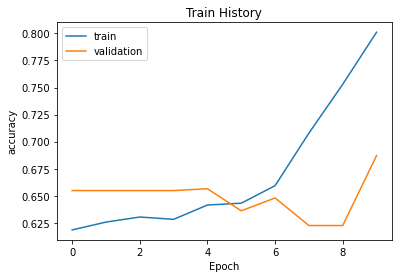

In [17]:
for train_history in train_history_list:
    show_train_history(train_history)

In [ ]:
index = 0
conv2D_config_list = [
    {'filters': 16, 'kernel_size': (2, 2), 'input_shape': (128, 128, 1), 'strides': (2, 2)},
    {'filters': 32, 'kernel_size': (2, 2), 'input_shape': (128, 128, 1), 'strides': (2, 2)}
]
dense_config_list = [
    {'unit': 128},
    {'unit': 128}
]
train_history = cnn_model.run(index=index, batch_size=100, epochs=10, conv2D_config_list=conv2D_config_list, dense_config_list=dense_config_list)
train_history_list.append(train_history)

In [11]:
import tensorflow.compat.v1 as tf
# import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow.keras.backend as K

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

In [16]:
# https://stackoverflow.com/questions/51298992/binary-classifier-keras-callback-for-sensitivity-and-specificity

def output_sensitivity_specificity(x_test, y_test):
    y_test = np.argmax(y_test, axis=-1)
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=-1)

    c = confusion_matrix(y_test, predictions)
    print('Confusion matrix:\n', c)
    print(f'sensitivity = {c[0, 0] / (c[0, 1] + c[0, 0])}')
    print(f'specificity = {c[1, 1] / (c[1, 1] + c[1, 0])}')

In [52]:
input_shape = np.shape(x_train[0])
print(input_shape)
batch_size = 100
epochs = 10
num_classes = 2

(128, 128, 1)


In [53]:
# loss_func = SparseCategoricalFocalLoss(gamma=2)
# y_true = [0, 1, 2]
# y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
# loss_func(y_true, y_pred)

In [71]:
# 建立簡單的線性執行的模型
model = Sequential()
# 建立卷積層，filter=16,即 output space 的深度, Kernal Size: 5x5, activation function 採用 relu
model.add(Conv2D(filters=32, 
                 kernel_size=(2, 2),
                 padding="same",
                 activation='relu',
                 input_shape=input_shape))

# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, 
                 kernel_size=(2, 2),
                 padding="same",
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.5))

# Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
model.add(Flatten())

# 全連接層: 128個output
model.add(Dense(128, activation='relu'))

# Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.5))

# 使用 softmax activation function，將結果分類
model.add(Dense(num_classes, activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
# model.compile(loss="categorical_crossentropy",
#               optimizer="adam",
#               metrics=['accuracy'])

# model.compile(loss=[SigmoidFocalCrossEntropy()], metrics=["accuracy"], optimizer="adam")
model.compile(loss=[multi_category_focal_loss2(alpha=0.25, gamma=2)], metrics=["accuracy"], optimizer="adam")

print(model.summary()) 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        4128      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [79]:
# 進行訓練, 訓練過程會存在 train_history 變數中

train_history = model.fit(x_train, 
                          y_train_onehot,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_split=0.2)

# 顯示損失函數、訓練成果(分數)
score = model.evaluate(x_test, y_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

output_sensitivity_specificity(x_test, y_test_onehot)

Train on 2348 samples, validate on 588 samples
Epoch 1/10
2348/2348 [==============================] - 1s 292us/sample - loss: 0.0098 - accuracy: 0.9672 - val_loss: 0.2436 - val_accuracy: 0.6990
Epoch 2/10
2348/2348 [==============================] - 1s 285us/sample - loss: 0.0097 - accuracy: 0.9664 - val_loss: 0.2228 - val_accuracy: 0.6939
Epoch 3/10
2348/2348 [==============================] - 1s 290us/sample - loss: 0.0091 - accuracy: 0.9702 - val_loss: 0.2165 - val_accuracy: 0.7007
Epoch 4/10
2348/2348 [==============================] - 1s 292us/sample - loss: 0.0111 - accuracy: 0.9634 - val_loss: 0.1992 - val_accuracy: 0.7007
Epoch 5/10
2348/2348 [==============================] - 1s 290us/sample - loss: 0.0105 - accuracy: 0.9681 - val_loss: 0.2150 - val_accuracy: 0.7007
Epoch 6/10
2348/2348 [==============================] - 1s 285us/sample - loss: 0.0096 - accuracy: 0.9629 - val_loss: 0.2359 - val_accuracy: 0.7143
Epoch 7/10
2348/2348 [==============================] - 1s 292us/

In [20]:
print(type(x_test))
print(np.shape(x_test))
print(type(y_test_onehot))
print(np.shape(y_test_onehot))

<class 'numpy.ndarray'>
(734, 128, 128, 1)
<class 'numpy.ndarray'>
(734, 2)


In [57]:
print(type(x_test_same_size))
print(np.shape(x_test_same_size))
print(type(y_test_onehot_same_size))
print(np.shape(y_test_onehot_same_size))

print(f'nodule count = {np.sum(y_test_same_size)}')

<class 'numpy.ndarray'>
(1318, 128, 128, 1)
<class 'numpy.ndarray'>
(1318, 2)
nodule count = 674


In [58]:
score = model.evaluate(x_test_same_size, y_test_onehot_same_size, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9626927503493469
Test accuracy: 0.60622156


In [1]:
par1={
    'Validation': 0.2, 
    'epoch': 40, 
    'Batch': 10
}
par = {
    'filter1':64,
    'filter2':128,
    'strides':1,
    'kernel': 2,
    'dropout1':0.5,
    'dropout2':0.5,
    'Neural':256
}

def DL_fun1(par,par1,x_train,y_train,x_test,y_test):
    result = None
    nf=par['filter1']
    nf1=par['filter2']
    ks=par['kernel']
    hs=np.shape(x)[1]
    ws=np.shape(x)[2]
    dr1=par['dropout1']
    dr2=par['dropout2']
    nn=par['Neural']
    vsr=par1['Validation']
    epn=par1['epoch']
    bs=par1['Batch']
    y_train_onehot = to_categorical(y_train)
    y_test_onehot = to_categorical(y_test)
    try:
        # 只使用 80% 的 GPU 記憶體config = tf.ConfigProto()
#         gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)
#         sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#         tf.keras.backend.set_session(sess)

        model = Sequential([
            Conv2D(filters=nf,kernel_size=(ks,ks),strides=(par['strides'],par['strides']),padding='same',input_shape=(hs,ws,1),activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(filters=nf1,kernel_size=(ks,ks),strides=(par['strides'],par['strides']),padding='same',input_shape=(hs,ws,1),activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(dr1),
            Flatten(),
            Dense(nn, activation='relu'),
            Dropout(dr2),
            Dense(3,activation='softmax'),
        ])
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        print(model.summary()) 
        train_history=model.fit(x=x_train,
                                y=y_train_onehot,
                                validation_split=vsr,
                                epochs=epn,
                                batch_size=bs,
                                verbose=2)
        scores=model.evaluate(x=x_test,y=y_test_onehot)
        result={'History':train_history, 'Score': scores}
        print(result)
    except Exception as e:
        print(traceback.format_exc())
    finally:
#         sess.close()
        pass
    return result

In [ ]:
result=DL_fun1(par,par1,x_train,y_train,x_test,y_test)

In [41]:
print(result)

None


In [13]:
def multi_category_focal_loss2(gamma=2., alpha=.25):
    """
    focal loss for multi category of multi label problem
    适用于多分类或多标签问题的focal loss
    alpha控制真值y_true为1/0时的权重
        1的权重为alpha, 0的权重为1-alpha
    当你的模型欠拟合，学习存在困难时，可以尝试适用本函数作为loss
    当模型过于激进(无论何时总是倾向于预测出1),尝试将alpha调小
    当模型过于惰性(无论何时总是倾向于预测出0,或是某一个固定的常数,说明没有学到有效特征)
        尝试将alpha调大,鼓励模型进行预测出1。
    Usage:
     model.compile(loss=[multi_category_focal_loss2(alpha=0.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    epsilon = 1.e-7
    gamma = float(gamma)
    alpha = tf.constant(alpha, dtype=tf.float32)

    def multi_category_focal_loss2_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
        alpha_t = y_true*alpha + (tf.ones_like(y_true)-y_true)*(1-alpha)
        y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
        ce = -tf.math.log(y_t)
        weight = tf.pow(tf.subtract(1., y_t), gamma)
        fl = tf.multiply(tf.multiply(weight, ce), alpha_t)
        loss = tf.reduce_mean(fl)
        return loss
    return multi_category_focal_loss2_fixed

In [ ]:
from tensorflow.python.keras.losses import LossFunctionWrapper

class SigmoidFocalCrossEntropy(LossFunctionWrapper):
    """Implements the focal loss function.
    Focal loss was first introduced in the RetinaNet paper
    (https://arxiv.org/pdf/1708.02002.pdf). Focal loss is extremely useful for
    classification when you have highly imbalanced classes. It down-weights
    well-classified examples and focuses on hard examples. The loss value is
    much high for a sample which is misclassified by the classifier as compared
    to the loss value corresponding to a well-classified example. One of the
    best use-cases of focal loss is its usage in object detection where the
    imbalance between the background class and other classes is extremely high.
    Usage:
    ```python
    fl = tfa.losses.SigmoidFocalCrossEntropy()
    loss = fl(
      [[0.97], [0.91], [0.03]],
      [[1.0], [1.0], [0.0]])
    print('Loss: ', loss.numpy())  # Loss: [0.00010971,
                                            0.0032975,
                                            0.00030611]
    ```
    Usage with tf.keras API:
    ```python
    model = tf.keras.Model(inputs, outputs)
    model.compile('sgd', loss=tf.keras.losses.SigmoidFocalCrossEntropy())
    ```
    Args
      alpha: balancing factor, default value is 0.25
      gamma: modulating factor, default value is 2.0
    Returns:
      Weighted loss float `Tensor`. If `reduction` is `NONE`, this has the same
          shape as `y_true`; otherwise, it is scalar.
    Raises:
        ValueError: If the shape of `sample_weight` is invalid or value of
          `gamma` is less than zero
    """

    def __init__(
        self,
        from_logits=False,
        alpha=0.25,
        gamma=2.0,
        reduction: str = tf.losses.Reduction.NONE,
        name: str = "sigmoid_focal_crossentropy",
    ):
        super().__init__(
            sigmoid_focal_crossentropy,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            alpha=alpha,
            gamma=gamma,
        )

def sigmoid_focal_crossentropy(
    y_true,
    y_pred,
    alpha=0.25,
    gamma=2.0,
    from_logits: bool = False,
):
    """
    Args
        y_true: true targets tensor.
        y_pred: predictions tensor.
        alpha: balancing factor.
        gamma: modulating factor.
    Returns:
        Weighted loss float `Tensor`. If `reduction` is `NONE`,this has the
        same shape as `y_true`; otherwise, it is scalar.
    """
    if gamma and gamma < 0:
        raise ValueError("Value of gamma should be greater than or equal to zero")

    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.convert_to_tensor(y_true, dtype=y_pred.dtype)

    # Get the cross_entropy for each entry
    ce = K.binary_crossentropy(y_true, y_pred, from_logits=from_logits)

    # If logits are provided then convert the predictions into probabilities
    if from_logits:
        pred_prob = tf.sigmoid(y_pred)
    else:
        pred_prob = y_pred

    p_t = (y_true * pred_prob) + ((1 - y_true) * (1 - pred_prob))
    alpha_factor = 1.0
    modulating_factor = 1.0

    if alpha:
        alpha = tf.convert_to_tensor(alpha, dtype=K.floatx())
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    if gamma:
        gamma = tf.convert_to_tensor(gamma, dtype=K.floatx())
        modulating_factor = tf.pow((1.0 - p_t), gamma)

    # compute the final loss and return
    return tf.reduce_sum(alpha_factor * modulating_factor * ce, axis=-1)

In [33]:
fl = SigmoidFocalCrossEntropy()
loss = fl(
  y_true = [[1.0], [1.0], [0.0]],
  y_pred = [[0.97], [0.91], [0.03]])
print('Loss: ', loss.numpy())  # Loss: [6.8532745e-06,
#                                         1.9097870e-04,
#                                         2.0559824e-05]

Loss:  [6.8532740e-06 1.9097868e-04 2.0559823e-05]
